# Digital homo- and heterodyne detection

In [1]:
import matplotlib.pyplot as plt
import cvxpy as cp
from tqdm import tqdm

import numpy as np
from scipy.special import factorial, eval_hermite
from scipy.integrate import quad
from qutip import *
from scipy.interpolate import interp1d
from scipy.stats import kstest
from joblib import Parallel, delayed
from bayes_opt import BayesianOptimization

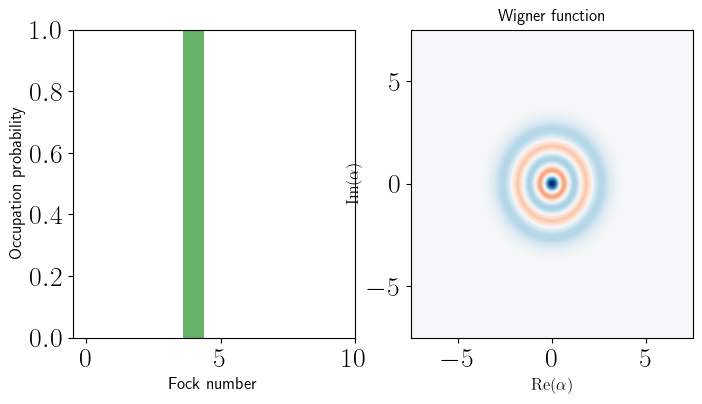

In [2]:
N=10

idc = qeye(N)
ida = qeye(2)
a  = tensor(destroy(N), ida)
sm = tensor(idc, destroy(2))
sx = tensor(idc, sigmax())
sy = tensor(idc, sigmay())
sz = tensor(idc, sigmaz())

# cavity photon number operator
N_cav = tensor(num(N), ida)

# projection operators to qubit ground and excited state
proj0 = tensor(idc, basis(2,0).proj())
proj1 = tensor(idc, basis(2,1).proj())


initial_cavity = coherent(N, 1j*1)

initial_cavity = fock(N,4) 

alpha = np.sqrt(6)
#initial_cavity = (coherent(N, alpha) + coherent(N,-alpha)).unit()

#initial_cavity = (fock(N, 1) + fock(N,2)).unit()

psi0 = tensor(initial_cavity, basis(2,0))

n_init = expect(N_cav, psi0)

plot_wigner_fock_distribution(initial_cavity);

In [3]:
def U_interact(g):
    op = (-1j) * g * (a.dag() * sm + a * sm.dag())
    return op.expm() 

def rotateX(theta):
    op = (-1j) * (theta/2) * sx
    return op.expm()

def rotateY(theta):
    op = (-1j) * (theta/2) * sy
    return op.expm()

def rotateXY(theta,rotangl):
    op = (-1j) * (theta/2) * (np.cos(rotangl)* sx + np.sin(rotangl)* sy)
    return op.expm()

# Time-dependent coupling

In [4]:
dt_total = 1
dt = 0.3

nangles = 10
thetas = np.linspace(0,np.pi, nangles) # list of all angles

# histogram parameters
Nbins = 60 # number of histogram bins
k = 6  # bin edge limit
dx =  2*k/Nbins # bin width

def find_first_zero(func, tol=1e-3, max=5000):
    for i in np.arange(max):
        if func(i) < tol:
            return i

# Tomography for time-dependent case

### Prepare operators

In [5]:
### Define the harmonic oscillator wavefunction
#To create homodyne POVM operators.

def wavefunction(x,n):
    const = 1/(np.sqrt(2**n * factorial(n)) * (np.pi)**0.25 )
    rest = const* np.exp(-x**2/2)
    return float(rest*eval_hermite(n,x))

### Construct operators

def get_Pis(theta, i):
    Pi = np.zeros((N,N),dtype=np.complex128)
    for m in range(N):
        wave_m = lambda x : wavefunction(x, m)
        for n in range(N):
            wave_n = lambda x: wavefunction(x, n)            
            func = lambda x: wave_m(x)*wave_n(x)
            Pi[n,m] = quad(func, -k + i*dx, -k + (i+1)*dx)[0]*np.exp(-1j*(n-m)*theta)
            
    return Pi*2 #

Pis = Parallel(n_jobs=16, verbose=0, backend="multiprocessing")(delayed(get_Pis)(theta,i) for theta in thetas for i in range(Nbins))

#The list `basis_dms` contains all $\Omega_k$
# construct vectors
basis_vectors = []
for i in range(N):
    vector = fock(N, i)
    basis_vectors.append(np.real(vector.full()))
    
# construct operators
basis_dms = []
for vector1 in basis_vectors:
    for vector2 in basis_vectors:
        dm = np.outer(vector1, vector2)
        basis_dms.append(dm)

### Construct the matrix A in $A\vec\rho=\vec b$
#From `Pis` and `basis_dms`.

def func(index, a):
    return np.trace(Pis[index[0]] @ basis_dms[index[1]])

A = np.zeros((len(Pis), N*N), dtype=np.complex64)
A_p = Parallel(n_jobs=16, verbose=0, backend="multiprocessing")(delayed(func)(idx,a) for idx, a in np.ndenumerate(A))

A = np.reshape(A_p, (len(Pis), N*N))

In [6]:
qbfeedback = rotateX(np.pi) # this pulse will reset the qubit if found in the excited state

prng = np.random.RandomState(12775425)

def get_measurements_hist_Nmeas(c, exp, rotangl, kappa, n_init):
        
    L = liouvillian(0*a, [np.sqrt(kappa*dt_total)*a])
    op = L.expm()

    
    qbrotmat = rotateXY(np.pi/2,rotangl) # qb rotation applied prior to qb measurement, defines measured homodyne quadrature
    
    quadmeashom = []
    
    def g_timedep(c,exp,i):
        return c*np.exp(exp*i*dt)
    
    def calc_weights(step):
        g_timedep_list = np.array([g_timedep(c,exp,i)/np.sqrt(dt) for i in range(step+1)])
        exponent = np.trapz(g_timedep_list**2,dx=dt)
        return  g_timedep(c,exp,step)*np.sqrt(1/2)*np.exp(-exponent/2)

    def pop_time_evol(step):
        g_timedep_list = np.array([g_timedep(c,exp,i)/np.sqrt(dt) for i in range(step+1)])
        exponent = np.trapz(g_timedep_list**2,dx=dt)
        return n_init*np.exp(-exponent)
        
    
    Nmeas = find_first_zero(pop_time_evol)
    print(Nmeas)
    calculated_weights = np.array([calc_weights(step) for step in range(Nmeas)])

    for j in tqdm(range(Ntrajs), leave=False):
        xrnd = prng.rand(Nmeas)

        results = []
        psi = ket2dm(psi0)

        for i in range(Nmeas):
            U_int = U_interact(g_timedep(c,exp,i))
            U = qbrotmat * U_int
            psi = U * psi * U.dag()
            prob = expect(proj0,psi)          

            # deterministic loss 
            vec_rho = operator_to_vector(psi)          
            psi = vector_to_operator(op*vec_rho)

            if prob > xrnd[i]:
                # measured g
                #results.append(-1 if error[i] <= correct_prob else 1) 
                results.append(-1)
                psi = (proj0 * psi * proj0).unit()
            else:
                #results.append(1 if error[i] <= correct_prob else -1)
                results.append(1)
                # measured e
                psi = (proj1 * psi * proj1 ).unit()
                # go back to g
                psi = qbfeedback * psi* qbfeedback.dag()
    
        quadmeashom.append(np.sum(results*calculated_weights))

    ### create histogram ###    
    hist, bins = np.histogram(quadmeashom,Nbins,[-k,k], density=True)    

    return hist 


In [26]:
kappa=0.002
Ntrajs = 1000

c = 0.15
exp = 0.07

In [29]:
b_all = Parallel(n_jobs=nangles, verbose=1, backend="loky")(delayed(get_measurements_hist_Nmeas)(c, exp, rotangl, kappa, n_init) for rotangl in thetas)

# Load homodyne data into vector $\vec b$
b = np.concatenate([array for array in b_all])

# Define the unknown state as a $N\times N$ Hermitian matrix

X = cp.Variable((N,N), hermitian=True)

#Set the cost function to $\|A\vec\rho - \vec b\|_2$ where the vectorized state is given by `cp.vec(X)`.

cost = cp.norm(A @ cp.vec(X) - b, 2) 

#Set the trace constraint and positive-semidefinite constraint
constraints = [cp.trace(X) == 1, X >> 0 ]

#Set up and solve the problem!

prob = cp.Problem(cp.Minimize(cost), constraints)
prob.solve(verbose=False)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
  0%|          | 0/1000 [00:00<?, ?it/s]

67
67
67
67
67
67
67
67
67
67


[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:  2.6min remaining: 10.5min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:  2.8min finished


2.0161420850802574

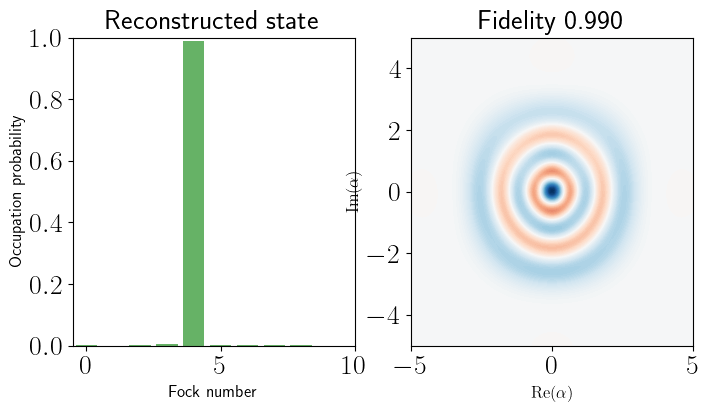

In [30]:
# Assign the optimized state X to a Qobj.
reconstructed_rho = Qobj(X.value)
f=fidelity(reconstructed_rho, initial_cavity)**2

#Plot the reconstructed state 
alpha_max = 5
fig, ax = plot_wigner_fock_distribution(reconstructed_rho, alpha_max=5)
ax[0].set_title("Reconstructed state")

f=fidelity(reconstructed_rho, initial_cavity)**2
ax[1].set_title("Fidelity %.3f"%(f));

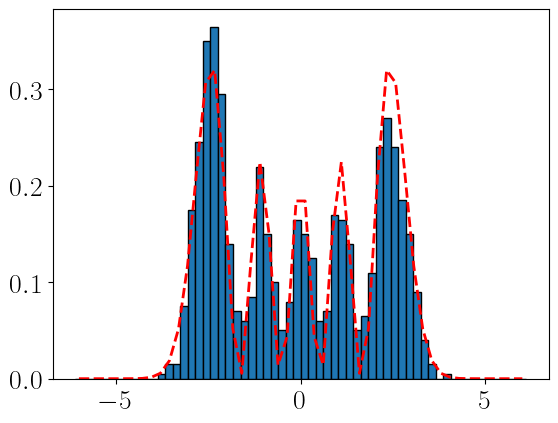

In [14]:
x_hist = np.linspace(-k,k,Nbins)
x = np.linspace(-k,k)
width = np.diff(x_hist)[0]
histogram = b_all[0]
W = wigner(initial_cavity, x, x)

marginal = np.trapz(W,x, axis=0)
plt.bar(x_hist,histogram , align='center', width=width, edgecolor='k',label='Samples' );
plt.plot(x,marginal, 'r--',linewidth=2, label='$W$ marginal');

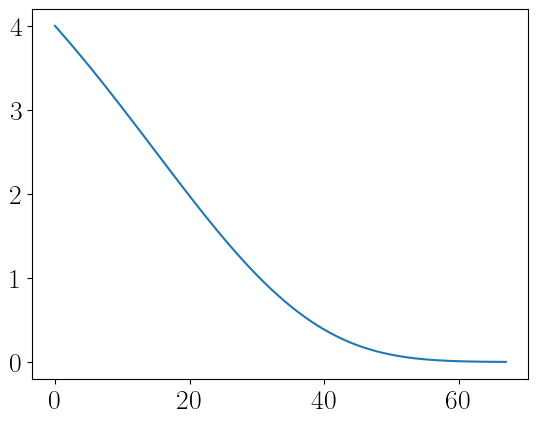

In [27]:
def g_timedep(c,exp,i):
    return c*np.exp(exp*i*dt)

def calc_weights(step):
    g_timedep_list = np.array([g_timedep(c,exp,i)/np.sqrt(dt) for i in range(step+1)])
    exponent = np.trapz(g_timedep_list**2,dx=dt)
    return  g_timedep(c,exp,step)*np.sqrt(1/2)*np.exp(-exponent/2)

def pop_time_evol(step):
    g_timedep_list = np.array([g_timedep(c,exp,i)/np.sqrt(dt) for i in range(step+1)])
    exponent = np.trapz(g_timedep_list**2,dx=dt)
    return n_init*np.exp(-exponent)

Nmeas = find_first_zero(pop_time_evol)
calculated_decay = np.array([pop_time_evol(step) for step in range(Nmeas+1)])
plt.plot(calculated_decay)

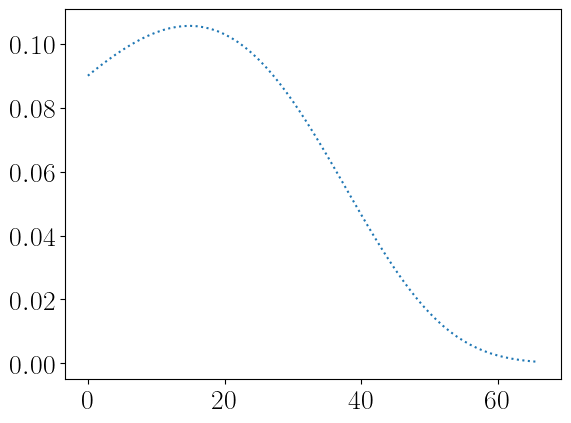

In [28]:
def calc_weights(step):
    g_timedep_list = np.array([g_timedep(c,exp,i)/np.sqrt(dt) for i in range(step+1)])
    exponent = np.trapz(g_timedep_list**2,dx=dt)
    return  g_timedep(c,exp, step)*np.sqrt(1/2)*np.exp(-exponent/2)

calculated_weights_timedep = np.array([calc_weights(step) for step in range(Nmeas)])

g_timedep_list = np.array([g_timedep(c,exp,i)/np.sqrt(dt) for i in range(Nmeas+1)])
pe = 2*(g_timedep_list)**2*dt*calculated_decay
plt.plot(2*calculated_weights_timedep**2*n_init,':', label='calc pe')